In [159]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest

from sklearn.metrics import auc
import xgboost as xgb


from sklearn.model_selection import train_test_split

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [160]:
df = pd.read_csv('criteo-uplift-v2.1.csv')

# ITE

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [162]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [163]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 13979592


In [164]:
df['treatment'].value_counts(normalize = True)

treatment
1    0.85
0    0.15
Name: proportion, dtype: float64

In [166]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])

In [170]:
X_train = train.drop(['visit','conversion',"treatment","exposure"],axis=1)
X_test = test.drop(['visit','conversion',"treatment","exposure"],axis=1)

T_train = train['treatment']
Y_train = train['visit']


T_test = test['treatment']
Y_test = test['visit']

# Meta-learner

In [ ]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.metrics.visualize import plot_tmlegain, plot_gain
from lightgbm import LGBMRegressor

learner_s = LRSRegressor()
learner_s.fit(X=X_train, treatment=T_train, y=Y_train)
cate_s = learner_s.predict(X=X_test, treatment=T_test)

In [ ]:

E_train = np.array(sum(T_train) / len(T_train))
E_test = np.array(sum(T_test) / len(T_test))

learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=T_train, y=Y_train, p=E_train)
cate_x = learner_x.predict(X=X_test, treatment=T_test, p=E_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1694
[LightGBM] [Info] Number of data points in the train set: 1678590, number of used features: 12
[LightGBM] [Info] Start training from score 0.038252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 9505083, number of used features: 12
[LightGBM] [Info] Start training from score 0.048522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [ ]:
# Evaluate the model using Qini metrics
df_result = pd.DataFrame({
    'outcome': Y_test,
    'is_treated': T_test,
    'treatment_effect': cate_x
})

In [ ]:
tmp = df_result.drop(columns=['outcome', 'is_treated'])

inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    tmp[col] = X_test[:,i]
    inference_cols.append(col)
x_learner_cor = tmp.corrwith(tmp['X-learner'])

In [ ]:
x_learner_cor

X-learner    1.000000
S-learner   -0.000325
causal       0.808304
col_0       -0.208271
col_1        0.369043
col_2        0.013838
col_3       -0.670517
col_4        0.212209
col_5       -0.422512
col_6       -0.486046
col_7        0.260672
col_8       -0.514374
col_9        0.522884
col_10       0.217278
col_11      -0.143203
dtype: float64

# causal forest

In [ ]:
!pip install causalml

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from causalml.inference.tree import CausalRandomForestRegressor
from causalml.metrics import plot_qini, plot_gain, qini_score
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.1/988.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 1.8 MB/s eta 0:00:0000:0100:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24551 sha256=b994cb6d28b406eaaee7defe595d36715bd887f34cd7696106001b650b464613
  Stored in directory: /Users/chengzhengxing/Library/Caches/pip/wheels/fe/cd/78/a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus


In [ ]:
cforest = CausalRandomForestRegressor(
    criterion="causal_mse", 
    control_name=0, 
    min_samples_leaf=200,
    n_estimators=50,
    n_jobs=-1,
    random_state=42
)

# Train the model
cforest.fit(X=X_train, treatment=T_train, y=Y_train)

# Predict treatment effects
ite_predictions = cforest.predict(X_test)

# Evaluate the model using Qini metrics
df_result = pd.DataFrame({
    'outcome': Y_test,
    'is_treated': T_test,
    'treatment_effect': ite_predictions
})

# Evaluation

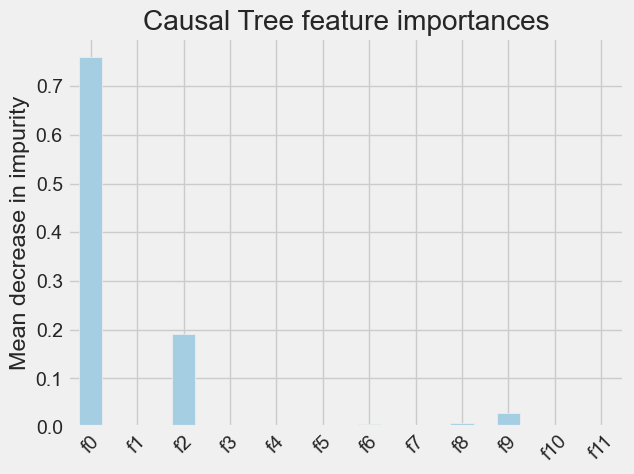

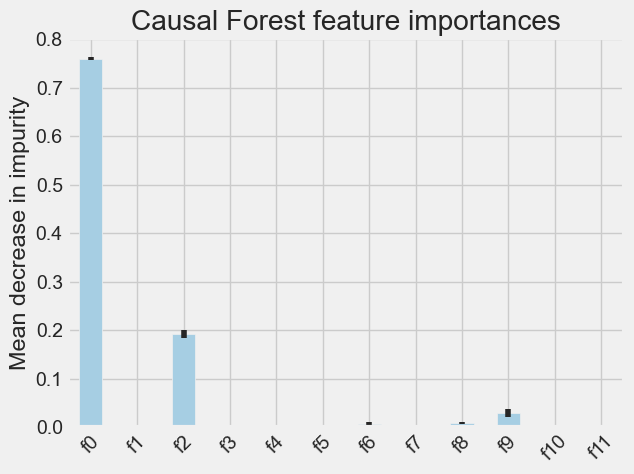

In [ ]:
feature_names = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
df_importances = pd.DataFrame({'tree': cforest.feature_importances_, 
                               'forest': cforest.feature_importances_,
                               'feature': feature_names
                              })
forest_std = np.std([tree.feature_importances_ for tree in cforest.estimators_], axis=0)

fig, ax = plt.subplots()
df_importances['tree'].plot.bar(ax=ax)
ax.set_title("Causal Tree feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

fig, ax = plt.subplots()
df_importances['forest'].plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Causal Forest feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

In [ ]:
tmp = df_result.drop(columns=['outcome', 'is_treated'])

inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    tmp[col] = X_test[:,i]
    inference_cols.append(col)
causal_cor = tmp.corrwith(tmp['causal'])

causal_cor

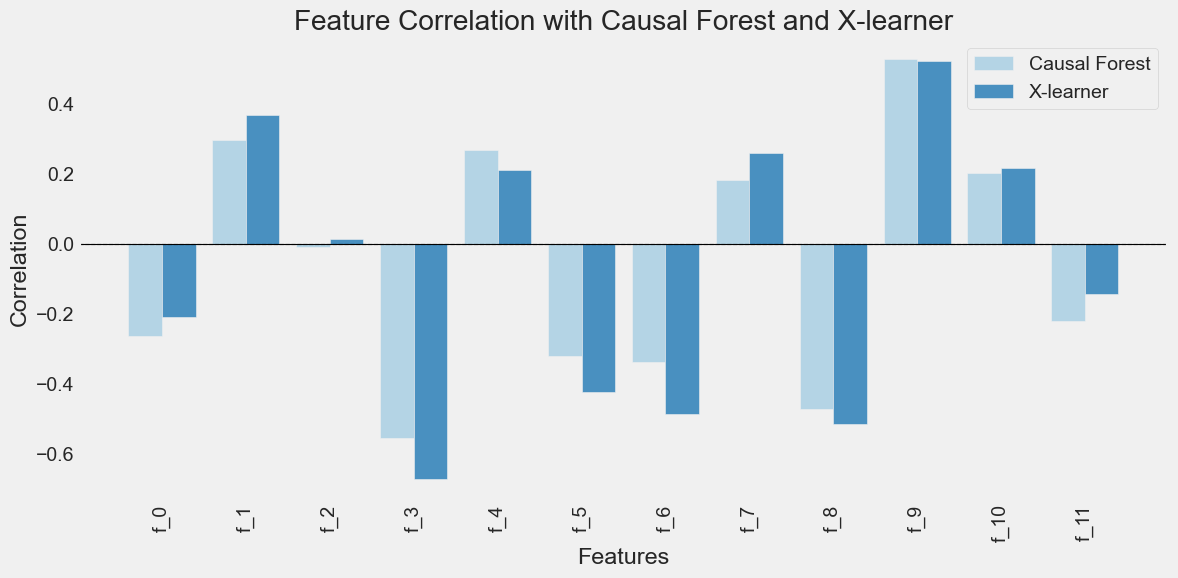

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for illustration
inference_cols = [f'f_{i}' for i in range(12)]  # Features from f_0 to f_9

# Plot the correlation
x = np.arange(len(inference_cols))  # Feature indices for the x-axis

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, causal_cor[3:], width=0.4, label='Causal Forest', alpha=0.8)
plt.bar(x + 0.2, x_learner_cor[3:], width=0.4, label='X-learner', alpha=0.8)

# Add labels, legend, and formatting
plt.xticks(x, inference_cols, rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Feature Correlation with Causal Forest and X-learner')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at y=0
plt.legend()
plt.tight_layout()
# Add x-axis and y-axis lines
#plt.axvline(x=0, color='black', linewidth=0.8)  # Y-axis line
plt.axhline(y=0, color='black', linewidth=0.8)  # X-axis line

# Remove grid lines
plt.grid(False)

# Show the plot
plt.show()


FixedFormatter should only be used together with FixedLocator


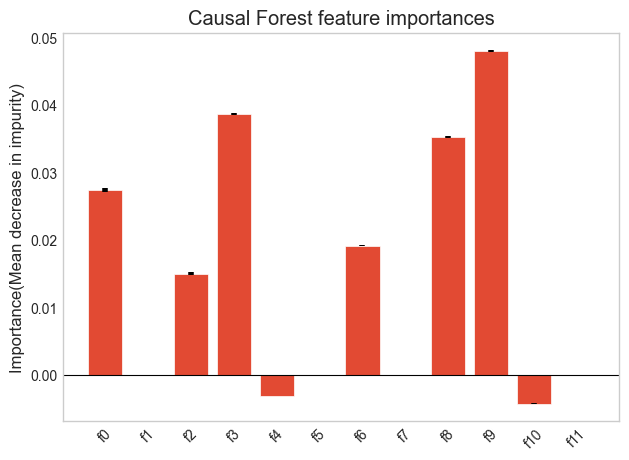

In [168]:
from sklearn.inspection import permutation_importance
for name, model in zip(('1'), (cforest)):
    
    imp = permutation_importance(model, X_test, Y_test,
                                 n_repeats=50,
                                 random_state=0)
    
    fig, ax = plt.subplots()
    ax.set_title(f"Causal Forest feature importances")
    ax.set_ylabel("Importance(Mean decrease in impurity)")
    #plt.axvline(x=0, color='black', linewidth=0.8) 
    plt.axhline(y=0, color='black', linewidth=0.8)  # X-axis line

    plt.bar(feature_names, imp['importances_mean'], yerr=imp['importances_std'])
    ax.set_xticklabels(feature_names, rotation=45)
    ax.grid(False)
    plt.show()

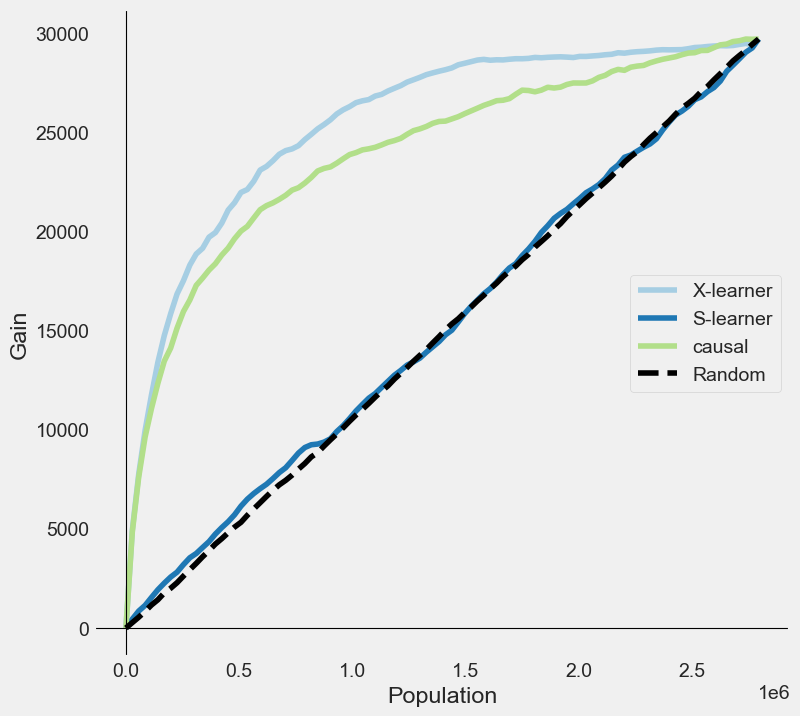

In [ ]:
df_result = pd.DataFrame({
    'outcome': Y_test,
    'is_treated': T_test,
    'X-learner': cate_x.flatten(),
    'S-learner':cate_s.flatten(),
    'causal': ite_predictions
})

plot_gain(df_result[['outcome', 'is_treated', 'X-learner','S-learner','causal']], outcome_col='outcome', treatment_col='is_treated')

random_line = plt.gca().lines[-1]  # Assuming the random line is the first line
random_line.set_linestyle('--')   # Set to dotted line
random_line.set_color('black')    # Set color to black
random_line.set_label('Random')  # Update the label  
plt.legend()
plt.axvline(x=0, color='black', linewidth=0.8)  # Y-axis line
plt.axhline(y=0, color='black', linewidth=0.8)  # X-axis line

# Remove grid lines
plt.grid(False)

plt.show()